### Task
* Create a model to predict the `revenue` of a given movie.  Evaluation will be based on the `mean_absolute_error` of 50 holdout movies, defined in the colab below.

### Imports

In [3]:
! pip3 install -q kagglehub[pandas-datasets]


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [4]:
! pip3 install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/c9/bc/b7db44f5f39f9d0494071bddae6880eb645970366d0a200022a1a93d57f5/pip-25.0.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [1]:
pip install -q -U google-genai

Note: you may need to restart the kernel to use updated packages.


In [2]:
! pip install -q google-cloud-automl

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import json
from sklearn.metrics import mean_absolute_percentage_error
from google import genai
from google.genai import types
import sklearn
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Load Data

In [40]:
credit_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tmdb/tmdb-movie-metadata",
  "tmdb_5000_credits.csv",
)

In [9]:
credit_data.head(1)

movie_id   title                                               cast  \
0     19995  Avatar  [{"cast_id": 242, "character": "Jake Sully", "...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...

In [4]:
movie_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "tmdb/tmdb-movie-metadata",
  "tmdb_5000_movies.csv",
)

# change column name to be consistent
movie_data.rename(
  columns={'id': 'movie_id'},
  inplace=True
)

100%|██████████| 1.58M/1.58M [00:00<00:00, 2.34MB/s]

Extracting zip of tmdb_5000_movies.csv...


In [5]:
movie_data.head(1)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                      homepage  movie_id  \
0  http://www.avatarmovie.com/     19995   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   

  original_title                                           overview  \
0         Avatar  In the 22nd century, a paraplegic Marine is di...   

   popularity                               production_companies  \
0  150.437577  [{"name": "Ingenious Film Partners", "id": 289...   

                                production_countries release_date     revenue  \
0  [{"iso_3166_1": "US", "name": "United States o...   2009-12-10  2787965087   

   runtime                                   spoken_languages    status  \
0    162.0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   

                       tagline   title  vote_average  vote_count  
0  Enter the World of Pandora.  Avatar           7.2       11800

In [10]:
tmdb_movie_data_all = pd.merge(
  movie_data,
  credit_data,
  on='movie_id'
)
tmdb_movie_data_all.head(3)

budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage  movie_id  \
0                   http://www.avatarmovie.com/     19995   
1  http://disney.go.com/disneypictures/pirates/       285   
2   http://www.sonypictures.com/movies/spectre/    206647   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...                en   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                            overview  popularity  \
0  In the 22nd century, a paraplegic Marine is di...  150.437577   
1  Captain Barbossa, long believed to be dead, ha...  139.082615   
2  A cryptic message from Bond’s past sends him o...  107.376788   

                                production_companies  ... runtime  \
0  [{"name": "Ingenious Film Partners", "id": 289...  ...   162.0   
1  [{"name": "Walt Disney Pictures", "id": 2}, {"...  ...   169.0   
2  [{"name": "Columbia Pictures", "id": 5}, {"nam...  ...   148.0   

                                    spoken_languages    status  \
0  [{"iso_639_1": "en", "name": "English"}, {"iso...  Released   
1           [{"iso_639_1": "en", "name": "English"}]  Released   
2  [{"iso_639_1": "fr", "name": "Fran\u00e7ais"},...  Released   

                                          tagline  \
0                     Enter the World of Pandora.   
1  At the end of the world, the adventure begins.   
2                           A Plan No One Escapes   

                                    title_x vote_average vote_count  \
0                                    Avatar          7.2      11800   
1  Pirates of the Caribbean: At World's End          6.9       4500   
2                                   Spectre          6.3       4466   

                                    title_y  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  

[3 rows x 23 columns]

In [12]:
tmdb_movie_data_all.columns

Index(['budget', 'genres', 'homepage', 'movie_id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title_x', 'vote_average', 'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [13]:
len(tmdb_movie_data_all['movie_id'])

4803

### Test Movie Ids
**You must exclude these ids from your training set of data.**

In [14]:
evaluation_data = (
  tmdb_movie_data_all[tmdb_movie_data_all['production_companies'].str.contains('Lionsgate')]
  .sort_values('revenue', ascending=False)
  .iloc[0:50, [3,12]]
)
evaluation_data.head(5)

movie_id    revenue
183    101299  847423452
200    131631  752100229
426     70160  691210692
102    131634  653428261
370    291805  334901337

In [15]:
evaluation_movie_ids = evaluation_data['movie_id'].to_numpy()
evaluation_revenue = evaluation_data['revenue'].to_numpy()

evaluation_movie_ids

array([101299, 131631,  70160, 131634, 291805, 262504,  41439,  11917,
        14435,  37821,  23483, 291870,  50348, 273481, 328387,   1690,
        76494, 100241,   5176,  22804,  22970, 243940,  10030,  19901,
        43539,   7445,  18501,  10431,   8285,   9794,   5393,  13596,
        60599,  15092, 157849, 210860,  14536, 200505,  59440, 127560,
        58431, 302156,    500,  12142,  13408,  13056, 157544,  14271,
       287424, 235271])

### Train Movie Ids

In [16]:
training_movie_ids = np.array([
  movie_id for movie_id in tmdb_movie_data_all['movie_id'] if movie_id not in evaluation_movie_ids
])

print(len(training_movie_ids))
training_movie_ids


4753


array([ 19995,    285, 206647, ..., 231617, 126186,  25975])

### Example Code to Unpack Json Column

In [17]:
tmdb_movie_data_all['cast'] = (
  tmdb_movie_data_all['cast']
  .apply(lambda x: json.loads(x))
)



In [18]:
tmdb_movie_data_all['cast'].head(10)

0    [{'cast_id': 242, 'character': 'Jake Sully', '...
1    [{'cast_id': 4, 'character': 'Captain Jack Spa...
2    [{'cast_id': 1, 'character': 'James Bond', 'cr...
3    [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...
4    [{'cast_id': 5, 'character': 'John Carter', 'c...
5    [{'cast_id': 30, 'character': 'Peter Parker / ...
6    [{'cast_id': 34, 'character': 'Flynn Rider (vo...
7    [{'cast_id': 76, 'character': 'Tony Stark / Ir...
8    [{'cast_id': 3, 'character': 'Harry Potter', '...
9    [{'cast_id': 18, 'character': 'Bruce Wayne / B...
Name: cast, dtype: object

In [19]:
#Lets get below attributes for model building:
# movie_id
# original_title
# genres
# overview
# popularity
# production Company
# release_data
# production_companies
# runtime
# tagline
# vote_avarega
# vote_count
# Cast1
# cast2
# Cast3


In [20]:
for i,r in tmdb_movie_data_all.iterrows():
  print(r)
  print(i)
  # for cast_i in r['cast']:
  #     cast_feature_data.append([r['movie_id'], cast_i['name']])

budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
homepage                                      http://www.avatarmovie.com/
movie_id                                                            19995
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
original_language                                                      en
original_title                                                     Avatar
overview                In the 22nd century, a paraplegic Marine is di...
popularity                                                     150.437577
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                               

In [28]:
credit_data['cast'] = (
  credit_data['cast']
  .apply(lambda x: json.loads(x))
)

cast_feature_data = []


for i,r in credit_data.iterrows():
  for cast_i in r['cast']:
      cast_feature_data.append([r['movie_id'], cast_i['name']])


cast_feature = pd.DataFrame(
  cast_feature_data,
  columns=['movie_id', 'cast_member']
)

In [29]:
cast_feature = pd.DataFrame(cast_feature_data)

In [30]:
cast_feature.head(20)

0                    1
0   19995      Sam Worthington
1   19995          Zoe Saldana
2   19995     Sigourney Weaver
3   19995         Stephen Lang
4   19995   Michelle Rodriguez
5   19995      Giovanni Ribisi
6   19995     Joel David Moore
7   19995          CCH Pounder
8   19995            Wes Studi
9   19995           Laz Alonso
10  19995           Dileep Rao
11  19995          Matt Gerald
12  19995   Sean Anthony Moran
13  19995          Jason Whyte
14  19995       Scott Lawrence
15  19995        Kelly Kilgour
16  19995   James Patrick Pitt
17  19995  Sean Patrick Murphy
18  19995         Peter Dillon
19  19995         Kevin Dorman

### Example Code to Call Gemini for an Embedding

* Embedding to represent the movie overview.
* Embedding to represent cast, such as an average of the embeddings for the entire cast.
* Could take the cast and overview and genres and get an embedding to represent all teh content as a single string.

In [49]:
api_key = "xxxxxxxxx"

In [42]:
client = genai.Client(api_key=api_key)

In [47]:
contents = movie_data['overview'].tolist()[0:5]

result = client.models.embed_content(
  model="gemini-embedding-exp-03-07",
  contents=contents,
  config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY"),
)

ClientError: 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'API key not valid. Please pass a valid API key.', 'status': 'INVALID_ARGUMENT', 'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'API_KEY_INVALID', 'domain': 'googleapis.com', 'metadata': {'service': 'generativelanguage.googleapis.com'}}, {'@type': 'type.googleapis.com/google.rpc.LocalizedMessage', 'locale': 'en-US', 'message': 'API key not valid. Please pass a valid API key.'}]}}

In [ ]:
embeddings = [x.values for x in result.embeddings]

In [ ]:
embeddings[0][0:3]

[-0.026876846, -0.00811482, 0.0046575973]

In [ ]:
embeddings[1][0:3]

[-0.039739244, -0.010465911, 0.022981776]

In [ ]:
len(embeddings[0])

3072

### Training Data

In [ ]:
train_data = movie_data[[
  "movie_id",
  "budget",
  "vote_average",
  "revenue"
]]

train_data = train_data[
  train_data["movie_id"].isin(training_movie_ids)
]

### Evaluation Data

In [ ]:
evaluation_data = movie_data[
  movie_data["movie_id"].isin(evaluation_movie_ids)
]

evaluation_features = evaluation_data[[
  "budget",
  "vote_average",
]]

### Modeling

In [ ]:
model_obj = (
  sklearn.
  linear_model
  .LinearRegression()
)


steps = [
  # insert data transformations
  # ('numeric_transformer', StandardScaler()),
  ('estimator', model_obj)
]


custom_pipeline = (
  sklearn
  .pipeline
  .Pipeline(steps=steps, verbose=True)
)

In [ ]:
custom_pipeline.fit(
  train_data[['budget', 'vote_average']],
  train_data['revenue']
)

[Pipeline] ......... (step 1 of 1) Processing estimator, total=   0.0s


Pipeline(steps=[('estimator', LinearRegression())], verbose=True)

### Evaluation

In [ ]:
evaluation_yhat = (
  custom_pipeline.predict(
    evaluation_data[[
      "budget",
      "vote_average"
    ]]
  )
)

predictions[0:5]

array([4.65987979e+08, 3.94192037e+08, 3.65785375e+08, 3.10510897e+08,
       2.67344271e+08])

In [ ]:
mean_absolute_percentage_error(
  evaluation_yhat,
  evaluation_revenue
)

1.253187871898392

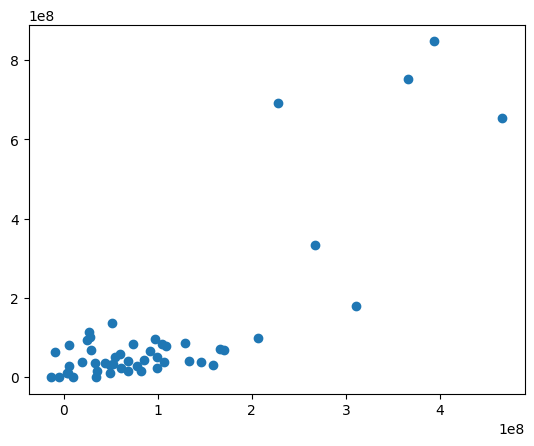

In [ ]:
plt.scatter(
  evaluation_yhat,
  evaluation_revenue
)